<a href="https://colab.research.google.com/github/jinwoo3239/Deepchem/blob/main/Chembl_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chembl tutorial

- ref1, [TeachOpenCADD](https://projects.volkamerlab.org/teachopencadd/all_talktorials.html)
- ref2, [github](https://github.com/StillWork/AIDD-2208-add/blob/main/c_83_4_ChEMBL_Data.ipynb)


In [ ]:
!pip install deepchem
!pip install chembl_webresource_client

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, Descriptors, rdMolDescriptors, PandasTools
from rdkit.Chem.Draw import IPythonConsole

import deepchem as dc

from chembl_webresource_client.new_client import new_client

plt.rc('font', family='calibri')

In [88]:
print(f'deepchem version = {dc.__version__}')

deepchem version = 2.6.1


In [89]:
target_api = new_client.target # Finding target... target_chembl_id
compound_api = new_client.molecule
activity_api = new_client.activity

## Target search
- selection of `target_chembl_id`

In [90]:
target_query = target_api.search('coronavirus')
targets = pd.DataFrame.from_dict(target_query)
targets[:2]
# selecting target chembl_id

# uniprot_id = 'P00533'
# target_query = target_api.get(target_components__accession=uniprot_id)
# targets = pd.DataFrame.from_dict(target_query)
# targets

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,[],Coronavirus,Coronavirus,17.0,False,CHEMBL613732,[],ORGANISM,11119
1,[],SARS coronavirus,SARS coronavirus,15.0,False,CHEMBL612575,[],ORGANISM,227859


In [91]:
target_chembl_id = 'CHEMBL3927'

activities = activity_api.filter(target_chembl_id=target_chembl_id,
                               standard_type='IC50',
                               standard_relation='=')

data = pd.DataFrame.from_dict(activities)
data.head(3)

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,1480935,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,BAO_0000357,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,7.2
1,None,1480936,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,BAO_0000357,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,9.4
2,None,1481061,[],CHEMBL830868,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,BAO_0000357,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,13.5


In [92]:
## EDA

data.isnull().sum()
columns = ['assay_chembl_id', 'assay_type', 'canonical_smiles',
           'standard_relation', 'standard_value', 'standard_units']

data = data[columns]
data.shape

(131, 6)

In [93]:
data.standard_units.value_counts()

nM    131
Name: standard_units, dtype: int64

In [94]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   assay_chembl_id    131 non-null    object
 1   assay_type         131 non-null    object
 2   canonical_smiles   131 non-null    object
 3   standard_relation  131 non-null    object
 4   standard_value     131 non-null    object
 5   standard_units     131 non-null    object
dtypes: object(6)
memory usage: 6.3+ KB


In [95]:
data = data.astype({'standard_value' : 'float32'})

In [96]:
data.shape

(131, 6)

**Add pIC50 values**  
As you can see the low IC50 values are difficult to read (values are distributed over multiple scales), which is why we convert the IC50 values to pIC50.

In [98]:
def pIC50_converter(IC50):
    # unit = nM
    if IC50 > 1e9:
        IC50 = 1e9
    pIC50 = 9 - np.log10(IC50)
    return pIC50

def activity_converter(pIC50):
    if pIC50 <= 5:
        return 'inactive'

    elif pIC50 > 6:
        return 'active'
    
    else:
        return 'intermediated'

data['pIC50'] = data.standard_value.apply(pIC50_converter)
data['activity'] = data.pIC50.apply(activity_converter)

In [99]:
# lipinski rules
# Mw <= 500, HBA <= 10, HBD <=5, logp <= 5,
# Linpinski rules are satisfied more than 3

def lipinski_rules_df(smiles):
    
    mol = Chem.MolFromSmiles(smiles)

    Mw = Descriptors.MolWt(mol)
    HBA = Descriptors.NumHAcceptors(mol)
    HBD = Descriptors.NumHDonors(mol)
    logp = Descriptors.MolLogP(mol)

    conditions = (sum([Mw, HBA, HBD, logp]) >= 3)

    return pd.Series(data = [Mw, HBA, HBD, logp, conditions],
                     index=['Mw', 'HBA', 'HBD', 'logP', 'linpinski_satisfied'])

In [100]:
lipinski_df = data.canonical_smiles.apply(lipinski_rules_df)

data = pd.concat([data, lipinski_df], axis=1)
data.head()

,assay_chembl_id,assay_type,canonical_smiles,standard_relation,standard_value,standard_units,pIC50,activity,Mw,HBA,HBD,logP,linpinski_satisfied
0,CHEMBL829584,B,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,=,7200.0,nM,5.142668,intermediated,281.271,5,0,1.89262,True
1,CHEMBL829584,B,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,=,9400.0,nM,5.026872,intermediated,415.589,2,0,3.81320,True
2,CHEMBL830868,B,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,=,13500.0,nM,4.869666,inactive,421.190,4,0,2.66050,True
3,CHEMBL829584,B,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,=,13110.0,nM,4.882397,inactive,293.347,3,0,3.63080,True
4,CHEMBL829584,B,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],=,2000.0,nM,5.698970,intermediated,338.344,5,0,3.53900,True


In [101]:
columns = ['assay_chembl_id', 'canonical_smiles', 'activity', 'pIC50', 'Mw', 'HBA', 'HBD', 'logP', 'linpinski_satisfied']

target_molecule_df = data[columns]
target_molecule_df.to_csv('target_molecule_df.csv', index=False)

In [102]:
df = pd.read_csv('target_molecule_df.csv')
df.head()

,assay_chembl_id,canonical_smiles,activity,pIC50,Mw,HBA,HBD,logP,linpinski_satisfied
0,CHEMBL829584,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,intermediated,5.142668,281.271,5,0,1.89262,True
1,CHEMBL829584,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,intermediated,5.026872,415.589,2,0,3.81320,True
2,CHEMBL830868,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,inactive,4.869666,421.190,4,0,2.66050,True
3,CHEMBL829584,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,inactive,4.882397,293.347,3,0,3.63080,True
4,CHEMBL829584,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],intermediated,5.698970,338.344,5,0,3.53900,True


## EDA

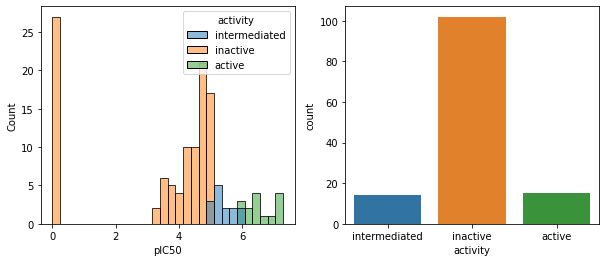

In [120]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.histplot(x='pIC50', data=df, bins=30, hue='activity')

plt.subplot(1, 2, 2)
sns.countplot(x='activity', data=df)
plt.show()

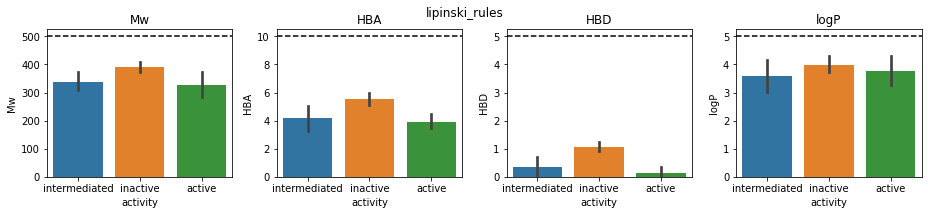

In [123]:
plt.figure(figsize=(13, 3))

plt.subplot(1, 4, 1)
sns.barplot(x='activity', y='Mw', data=df,)
plt.axhline(y=500, color='k', linestyle='--')
plt.title('Mw')

plt.subplot(1, 4, 2)
sns.barplot(x='activity', y='HBA', data=df)
plt.axhline(y=10, color='k', linestyle='--')
plt.title('HBA')

plt.subplot(1, 4, 3)
sns.barplot(x='activity', y='HBD', data=df)
plt.axhline(y=5, color='k', linestyle='--')
plt.title('HBD')

plt.subplot(1, 4, 4)
sns.barplot(x='activity', y='logP', data=df)
plt.axhline(y=5, color='k', linestyle='--')
plt.title('logP')

plt.suptitle('lipinski_rules')
plt.tight_layout()
plt.show()

## Molecular filtering: unwanted substructures
- reference [(TeachOpenCADD)](https://projects.volkamerlab.org/teachopencadd/talktorials/T003_compound_unwanted_substructures.html)


**Unwanted substructures**  
Substructures can be unfavorable, e.g., because they are toxic or reactive, due to unfavorable pharmacokinetic properties, or because they likely interfere with certain assays. Nowadays, drug discovery campaigns often involve high throughput screening. Filtering unwanted substructures can support assembling more efficient screening libraries, which can save time and resources. Brenk et al. (Chem. Med. Chem. (2008), 3, 435-44) have assembled a list of unfavorable substructures to filter their libraries used to screen for compounds to treat neglected diseases. Examples of such unwanted features are nitro groups (mutagenic), sulfates and phosphates (likely resulting in unfavorable pharmacokinetic properties), 2-halopyridines and thiols (reactive). This list of undesired substructures was published in the above mentioned paper and will be used in the practical part of this talktorial.

**Pan Assay Interference Compounds (PAINS)**  
PAINS are compounds that often occur as hits in HTS even though they actually are false positives. PAINS show activity at numerous targets rather than one specific target. Such behavior results from unspecific binding or interaction with assay components. Baell et al. (J. Med. Chem. (2010), 53, 2719-2740) focused on substructures interfering in assay signaling. They described substructures which can help to identify such PAINS and provided a list which can be used for substructure filtering.